# Classificação de poemas de heterónimos de Fernando Pessoa

## Experiência Interruptor com modelo LDA

## Passo 1: Importar as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import pickle 
import pyLDAvis

## Passo 1: Carregar os dados e filtrá-los

In [2]:
df = pd.read_csv('textos-pessoa.csv', index_col="autor")
df.head(10)

,título,texto,data,tipo
autor,,,,
Fernando Pessoa,ESTÉTICA - Um exemplo especialmente precioso é...,ESTÉTICA Um exemplo especialmente precioso é ...,1916?,prosa
Fernando Pessoa,"Há três espécies de Portugal, dentro do mesmo ...","Há três espécies de Portugal, dentro do mesmo ...",s.d.,prosa
Alberto Caeiro,"Verdade, mentira, certeza, incerteza…","Verdade, mentira, certeza, incerteza…\nAquele ...",12-4-1919,poesia
Ricardo Reis,OS DEUSES: DEFESA DELES,"OS DEUSES: DEFESA DELES\n\nTemos, como único d...",s.d.,prosa
Fernando Pessoa,[Carta a Ophélia Queiroz - 1 Mar. 1920],"Ophelinha:\n\nPara me mostrar o seu desprezo, ...",1-3-1920,prosa
Fernando Pessoa,Out of a great nebula of Night and Storm,Out of a great nebula of Night and Storm \nBor...,5-5-1915,prosa
Barão de Teive,"Viu-a desaparecer com mágoa, com rancor,","Viu-a desaparecer com mágoa, com rancor, com h...",s.d.,prosa
Alberto Caeiro,O amor é uma companhia,O amor é uma companhia.\nJá não sei andar só p...,10-7-1930,poesia
Fernando Pessoa,PRECISAMOS CRIAR PORTUGUESES,PRECISAMOS CRIAR PORTUGUESES\n\n\nO fundo da r...,s.d.,prosa


## Passo 2: Preprocessamento: stemização, lematização, etc. 

Deixamos cair os heterónimos que não precisamos.

In [3]:
df.reset_index(inplace=True)

autores_principais = ['Fernando Pessoa', 'Bernardo Soares', 'Álvaro de Campos', 'Ricardo Reis', 'Alberto Caeiro']
dados = df[df['autor'].isin(autores_principais)].copy()
dados.autor.value_counts()

Fernando Pessoa     2814
Bernardo Soares      504
Álvaro de Campos     397
Ricardo Reis         307
Alberto Caeiro       127
Name: autor, dtype: int64

In [4]:
df

,autor,título,texto,data,tipo
0,Fernando Pessoa,ESTÉTICA - Um exemplo especialmente precioso é...,ESTÉTICA Um exemplo especialmente precioso é ...,1916?,prosa
1,Fernando Pessoa,"Há três espécies de Portugal, dentro do mesmo ...","Há três espécies de Portugal, dentro do mesmo ...",s.d.,prosa
2,Alberto Caeiro,"Verdade, mentira, certeza, incerteza…","Verdade, mentira, certeza, incerteza…\nAquele ...",12-4-1919,poesia
3,Ricardo Reis,OS DEUSES: DEFESA DELES,"OS DEUSES: DEFESA DELES\n\nTemos, como único d...",s.d.,prosa
4,Fernando Pessoa,[Carta a Ophélia Queiroz - 1 Mar. 1920],"Ophelinha:\n\nPara me mostrar o seu desprezo, ...",1-3-1920,prosa
...,...,...,...,...,...
4525,Eduardo Lança,ESTÁTUAS,ESTÁTUAS\n\nO bom Deus - em pequeno ouvi dizer...,24-5-1902,poesia
4526,Fernando Pessoa,«Vesti-me toda de novo,«Vesti-me toda de novo\n\n«Vesti-me toda de no...,s.d.,poesia
4527,Fernando Pessoa,ESTÉTICA - Um grande artista (literário) nota-...,ESTÉTICA\n\nUm grande artista (literário) nota...,1925?,prosa
4528,Bernardo Soares,"Por fácil que seja, todo o gesto representa a ...","Por fácil que seja, todo o gesto representa a ...",s.d.,prosa


Removemos pontuação, maiúsculas e quebras de linha.


In [5]:
def limpar_texto(serie_pandas):
    novo_texto = re.sub(r'[^\w\s]', ' ', serie_pandas).lower()
    novo_texto = re.sub(r'[\n]', ' ', novo_texto).lower()
    return novo_texto

dados.texto = dados.texto.apply(limpar_texto)
dados

,autor,título,texto,data,tipo
0,Fernando Pessoa,ESTÉTICA - Um exemplo especialmente precioso é...,estética um exemplo especialmente precioso é ...,1916?,prosa
1,Fernando Pessoa,"Há três espécies de Portugal, dentro do mesmo ...",há três espécies de portugal dentro do mesmo ...,s.d.,prosa
2,Alberto Caeiro,"Verdade, mentira, certeza, incerteza…",verdade mentira certeza incerteza aquele c...,12-4-1919,poesia
3,Ricardo Reis,OS DEUSES: DEFESA DELES,os deuses defesa deles temos como único dad...,s.d.,prosa
4,Fernando Pessoa,[Carta a Ophélia Queiroz - 1 Mar. 1920],ophelinha para me mostrar o seu desprezo ou...,1-3-1920,prosa
...,...,...,...,...,...
4523,Fernando Pessoa,"A nossa ânsia de verdade é grande,",a nossa ânsia de verdade é grande e por certo...,s.d.,prosa
4526,Fernando Pessoa,«Vesti-me toda de novo,vesti me toda de novo vesti me toda de novo...,s.d.,poesia
4527,Fernando Pessoa,ESTÉTICA - Um grande artista (literário) nota-...,estética um grande artista literário nota s...,1925?,prosa
4528,Bernardo Soares,"Por fácil que seja, todo o gesto representa a ...",por fácil que seja todo o gesto representa a ...,s.d.,prosa


Removemos texto em inglês.

In [6]:
dados = dados[dados.texto.apply(lambda x : detect(x))!='en']

In [7]:
dados

,autor,título,texto,data,tipo
0,Fernando Pessoa,ESTÉTICA - Um exemplo especialmente precioso é...,estética um exemplo especialmente precioso é ...,1916?,prosa
1,Fernando Pessoa,"Há três espécies de Portugal, dentro do mesmo ...",há três espécies de portugal dentro do mesmo ...,s.d.,prosa
2,Alberto Caeiro,"Verdade, mentira, certeza, incerteza…",verdade mentira certeza incerteza aquele c...,12-4-1919,poesia
3,Ricardo Reis,OS DEUSES: DEFESA DELES,os deuses defesa deles temos como único dad...,s.d.,prosa
4,Fernando Pessoa,[Carta a Ophélia Queiroz - 1 Mar. 1920],ophelinha para me mostrar o seu desprezo ou...,1-3-1920,prosa
...,...,...,...,...,...
4523,Fernando Pessoa,"A nossa ânsia de verdade é grande,",a nossa ânsia de verdade é grande e por certo...,s.d.,prosa
4526,Fernando Pessoa,«Vesti-me toda de novo,vesti me toda de novo vesti me toda de novo...,s.d.,poesia
4527,Fernando Pessoa,ESTÉTICA - Um grande artista (literário) nota-...,estética um grande artista literário nota s...,1925?,prosa
4528,Bernardo Soares,"Por fácil que seja, todo o gesto representa a ...",por fácil que seja todo o gesto representa a ...,s.d.,prosa


In [8]:
# remover stopwords

stopwords_pt = nltk.corpus.stopwords.words('portuguese')
stopwords_pt.append("porque")
dados['sem_stopwords'] = dados.apply(lambda x : ' '.join([palavra for palavra in x['texto'].split(' ') if palavra not in stopwords_pt]), axis = 1)


/home/rute/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [9]:
#tokenização

nltk.download('punkt')

tokens = nltk.word_tokenize(dados['sem_stopwords'][2])
dados['tokens'] = dados['sem_stopwords'].apply(nltk.word_tokenize)


[nltk_data] Downloading package punkt to /home/rute/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/rute/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
# Stemming
nltk.download('rslp')
ps = nltk.stem.RSLPStemmer()

dados['raiz'] = dados.apply(lambda x : [ps.stem(palavra) for palavra in x['tokens']], axis = 1)



[nltk_data] Downloading package rslp to /home/rute/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
/home/rute/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Word Cloud

In [11]:
wordcloud_df = dados

ric_reis = wordcloud_df[wordcloud_df["autor"] == "Ricardo Reis"]
alv_camp = wordcloud_df[wordcloud_df["autor"] == "Álvaro de Campos"]
alb_caer = wordcloud_df[wordcloud_df["autor"] == "Alberto Caeiro"]
fern_pes = wordcloud_df[wordcloud_df["autor"] == "Fernando Pessoa"]
bern_soar = wordcloud_df[wordcloud_df["autor"] == "Bernardo Soares"]

Ricardo Reis


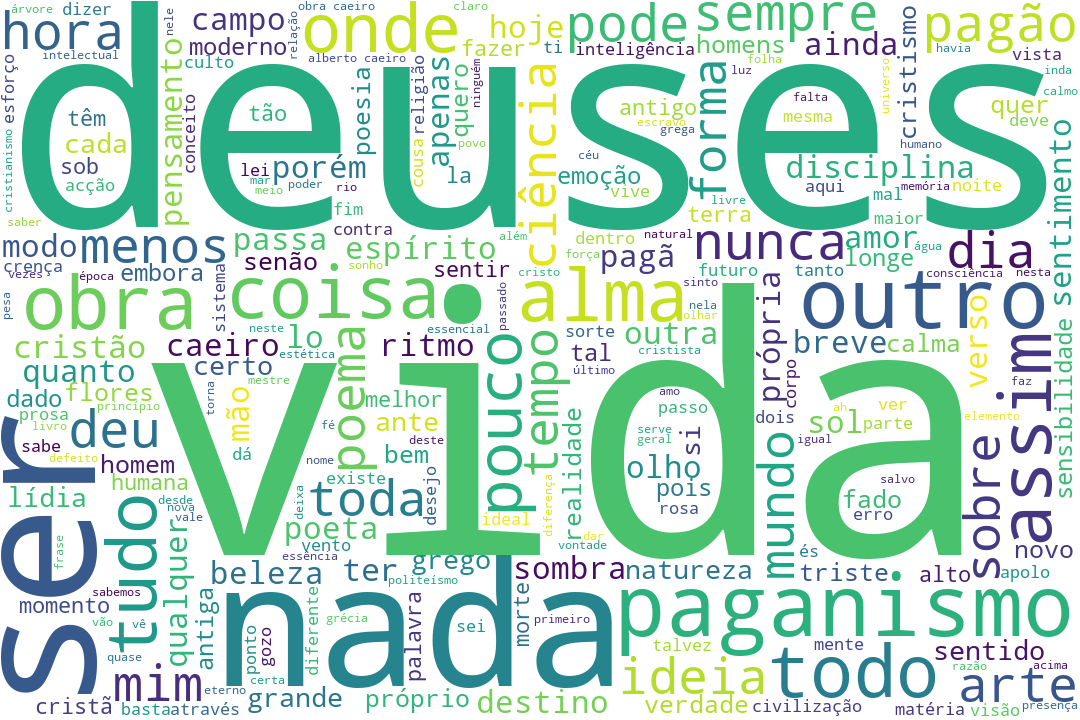

In [12]:
# Join the different processed titles together.
long_string_rr = ','.join(list(ric_reis['sem_stopwords'].values))
long_string_alv = ','.join(list(alv_camp['sem_stopwords'].values))
long_string_alb = ','.join(list(alb_caer['sem_stopwords'].values))
long_string_fp = ','.join(list(fern_pes['sem_stopwords'].values))
long_string_bs = ','.join(list(bern_soar['sem_stopwords'].values))

# Create a WordCloud object
#https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

wordcloud = WordCloud(background_color="white", width=1080, height=720, max_words=250)

# Generate a word cloud

# Visualize the word cloud
print("Ricardo Reis")
wordcloud.generate(long_string_rr)
wordcloud.to_file("nuvem-ricardo-reis.png")
wordcloud.to_image()

Álvaro de Campos


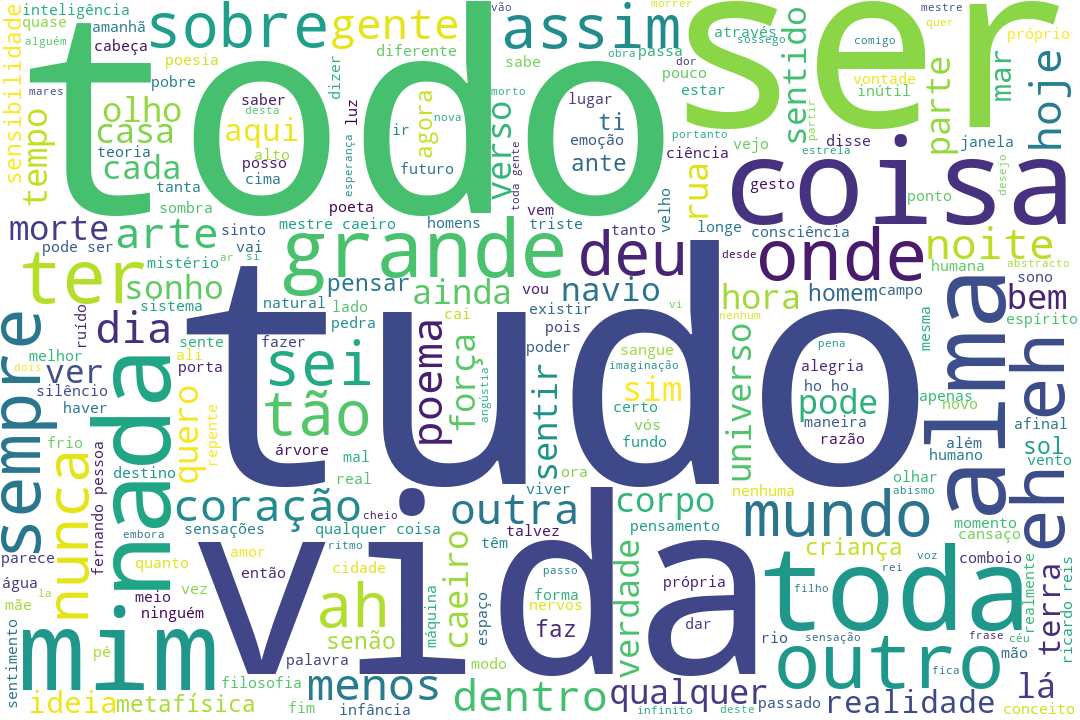

In [13]:
print("Álvaro de Campos")
wordcloud.generate(long_string_alv)
wordcloud.to_file("nuvem-alvaro-campos.png")
wordcloud.to_image()

Alberto Caeiro


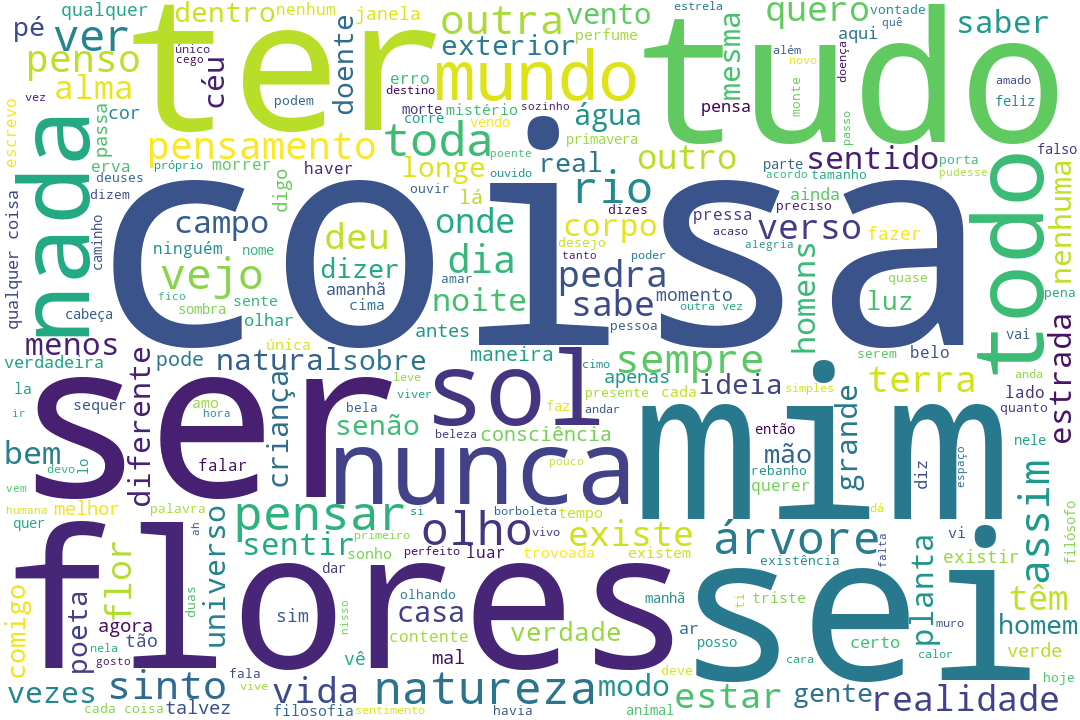

In [14]:
print("Alberto Caeiro")
wordcloud.generate(long_string_alb)
wordcloud.to_file("nuvem-alberto-caeiro.png")
wordcloud.to_image()

Fernando Pessoa


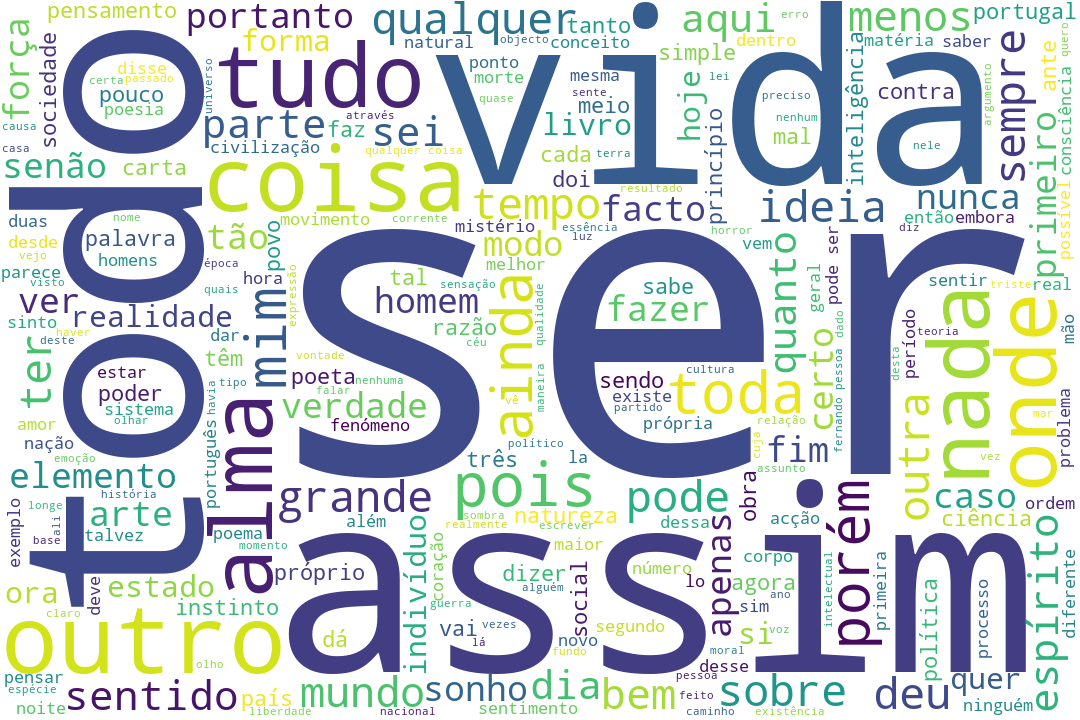

In [15]:
print("Fernando Pessoa")
wordcloud.generate(long_string_fp)
wordcloud.to_file("nuvem-fernando-pessoa.png")
wordcloud.to_image()

Bernardo Soares


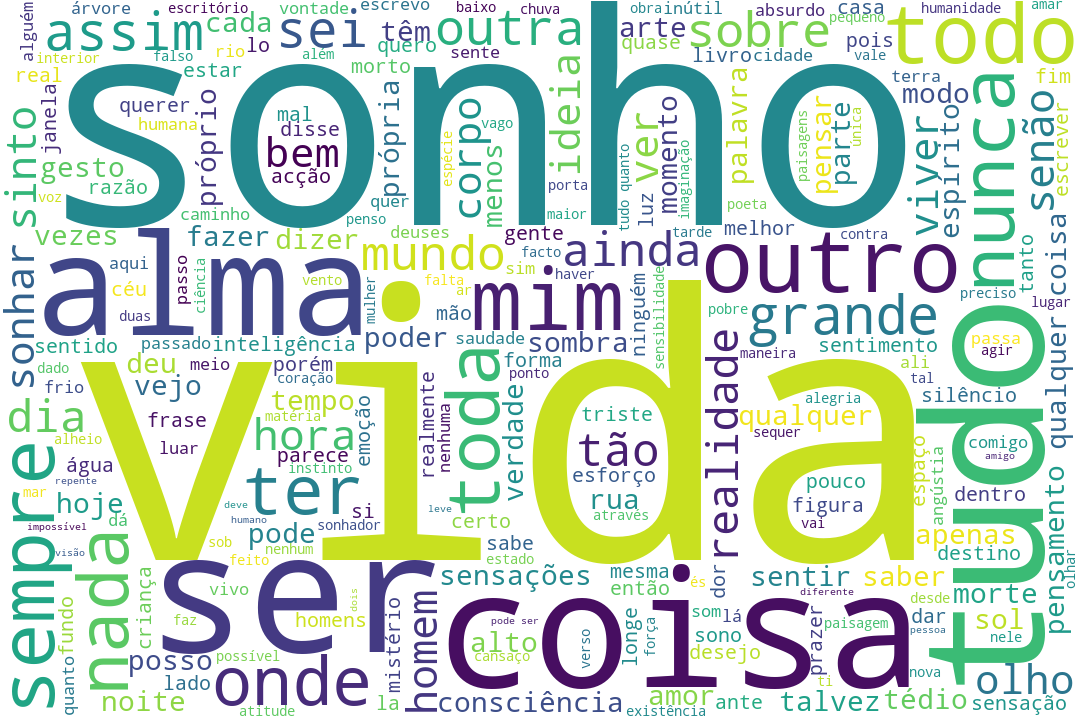

In [16]:
print("Bernardo Soares")
wordcloud.generate(long_string_bs)
wordcloud.to_file("nuvem-bernardo-soares.png")
wordcloud.to_image()

# Train / Test

In [17]:
y = dados['tokens']
X = dados.drop(['tokens'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


# Bag of Words

In [18]:
processed_docs = y_train

id2word = gensim.corpora.Dictionary(processed_docs)

In [19]:
processed_docs

1688    [sol, casas, montes, vagamente, doura, cidade,...
133     [regresso, lar, quanto, tempo, escrevo, soneto...
3952    [razões, supor, adiante, direi, quais, dois, t...
266     [futurismo, vem, ser, fotografia, abstracta, c...
4141    [athena, supondo, revista, mercure, 500, rs, 1...
                              ...                        
177     [saudação, todos, quantos, querem, ser, felize...
3271    [dói, coração, coisas, lindas, nunca, existirã...
4462    [pobre, espanha, ter, alma, onde, ser, fragmen...
1118    [andorinha, passaste, andorinha, passaste, esp...
1976    [adiamento, amanhã, sim, amanhã, levarei, aman...
Name: tokens, Length: 2559, dtype: object

In [20]:
id2word.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
corpus = [id2word.doc2bow(doc) for doc in processed_docs]

In [21]:
#printing for testing/checking

document_num = 20
bow_doc_x = corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     id2word[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))



Word 33 ("gente") appears 1 time.
Word 229 ("prazer") appears 2 time.
Word 278 ("espaço") appears 1 time.
Word 288 ("asas") appears 1 time.
Word 305 ("conheço") appears 1 time.
Word 347 ("fazem") appears 1 time.
Word 354 ("gesto") appears 1 time.
Word 385 ("mãos") appears 1 time.
Word 391 ("olhos") appears 1 time.
Word 462 ("vêm") appears 1 time.
Word 510 ("buscar") appears 1 time.
Word 511 ("chove") appears 4 time.
Word 512 ("chuva") appears 1 time.
Word 513 ("constantemente") appears 1 time.
Word 514 ("corpo") appears 1 time.
Word 515 ("crime") appears 1 time.
Word 516 ("dentro") appears 1 time.
Word 517 ("esforço") appears 1 time.
Word 518 ("frio") appears 3 time.
Word 519 ("gestos") appears 1 time.
Word 520 ("indiferente") appears 1 time.
Word 521 ("inerte") appears 1 time.
Word 522 ("lábios") appears 1 time.
Word 523 ("negro") appears 1 time.
Word 524 ("oculta") appears 1 time.
Word 525 ("olhares") appears 1 time.
Word 526 ("vir") appears 1 time.
Word 527 ("és") appears 2 time.
Wo

In [22]:
lda_model =  gensim.models.LdaMulticore(corpus, 
                                   num_topics = 10, 
                                   id2word = id2word,                 
                                   passes = 20, alpha = 0.02,
                                   workers = 2)

In [23]:
'''
For each topic, these are the words occuring in that topic and their relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")



Topic: 0 
Words: 0.008*"caeiro" + 0.007*"sinto" + 0.006*"sol" + 0.006*"mar" + 0.006*"sonhos" + 0.005*"talvez" + 0.005*"gente" + 0.005*"céu" + 0.005*"flores" + 0.005*"quero"


Topic: 1 
Words: 0.015*"realidade" + 0.013*"objecto" + 0.013*"infinito" + 0.012*"ciência" + 0.012*"espaço" + 0.012*"consciência" + 0.011*"relação" + 0.010*"sensação" + 0.009*"universo" + 0.009*"número"


Topic: 2 
Words: 0.012*"amor" + 0.011*"ó" + 0.010*"noite" + 0.008*"ti" + 0.008*"coração" + 0.006*"vem" + 0.006*"lá" + 0.005*"hora" + 0.005*"amanhã" + 0.005*"olhos"


Topic: 3 
Words: 0.034*"2" + 0.032*"1" + 0.028*"3" + 0.017*"escritório" + 0.017*"4" + 0.016*"carta" + 0.015*"poemas" + 0.014*"casa" + 0.014*"c" + 0.011*"5"


Topic: 4 
Words: 0.020*"arte" + 0.014*"inteligência" + 0.009*"emoção" + 0.009*"ideia" + 0.008*"realidade" + 0.007*"espírito" + 0.007*"sensibilidade" + 0.007*"forma" + 0.007*"poeta" + 0.007*"ciência"


Topic: 5 
Words: 0.009*"social" + 0.006*"espírito" + 0.006*"civilização" + 0.006*"três" + 0.005*

In [24]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=dados['tokens'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)




Coherence Score:  0.49807172961242036


In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_train = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#pyLDAvis.save_html(LDAvis_train, 'lda.html')
LDAvis_train





PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.191196  0.016429       1        1  21.818426
0      0.155885  0.027906       2        1  15.578918
6     -0.078951 -0.080008       3        1  15.048543
2      0.217400  0.003519       4        1  11.103558
4     -0.156837  0.052702       5        1  10.951026
8     -0.130536 -0.025033       6        1   7.317959
1     -0.093847  0.103375       7        1   5.327139
7      0.143137  0.112188       8        1   4.933743
9      0.078982  0.093978       9        1   4.302958
3      0.055963 -0.305058      10        1   3.617730, topic_info=         Term        Freq       Total Category  logprob  loglift
105         2  411.000000  411.000000  Default  30.0000  30.0000
104         1  398.000000  398.000000  Default  29.0000  29.0000
106         3  338.000000  338.000000  Default  28.0000  28.0000
100      arte  512.000000  512.000000  Default  27.0000  27.0000
297     carta  289.000000  289.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
787   ricardo   37.884617   96.335487  Topic10  -5.2152   2.3860
111    caeiro   46.582455  332.139221  Topic10  -5.0085   1.3550
1161     duas   44.645351  446.977295  Topic10  -5.0510   1.0156
2282   álvaro   35.944832  105.771393  Topic10  -5.2677   2.2400
777        lá   37.770050  314.943756  Topic10  -5.2182   1.1984

[636 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
104       1  0.218400     1
104       3  0.050207     1
104       4  0.005021     1
104       5  0.052717     1
104       6  0.015062     1
...     ...       ...   ...
579       5  0.025202  ódio
579       6  0.063004  ódio
579       7  0.063004  ódio
579       8  0.189012  ódio
579       9  0.403225  ódio

[2818 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 7, 3, 5, 9, 2, 8, 10, 4])